# Optimization : Place the biggest possible house on a land

Constraints for the problem : 
- The house is a rectangle
- The land is any polygon, it can be convex or concave



The optimization is implemented with two different optimizers : PSO and DE

<a id="tableOfContents"></a>
### Table of contents :
- <a href="#section1">Problem definition</a>, a rectangle in a polygon
- <a href="#section2">PSO algorithm</a> 
- <a href="#section3">DE algorithm</a> 
- <a href="#section4">Optimizers comparison</a>
- <a href="#section5">Comparison result</a>

In [36]:
from math import sqrt
import time
import pandas as pd

from sympy.geometry import Polygon as SympyPolygon
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon

from tqdm import tqdm
from IPython.display import Markdown, display, clear_output
def printmd(string):
    display(Markdown(string))

In [2]:
from ipynb.fs.full.Rectangle import Rectangle
from ipynb.fs.full.Rectangle import create_animation, draw_polygons, draw_polygon, get_color
from ipynb.fs.full.Rectangle import erase_logs, LOGS

In [3]:
from ipynb.fs.full.OptimizerBuilder import OptimizerBuilder

<a id="section1"></a> 
## 1 - Definition of the problem 
<a href="#tableOfContents">Go back to the table of contents</a>

You can look at the Rectangle.ipynb notebook to see the class and functions related to the problem definition. It contains all the necessary functions to draw the problem, and generate animations.

In [4]:
poly1 = [(0,0), (0,100), (100,100), (110, 50), (100, 0)]
poly2 = [(0,0), (0,100), (50,90), (30,40), (71,25), (71,100), (100,100), (100,0)]
poly3 = [(0,0), (0,100), (30,90), (40,40), (71,25), (71,100), (100,100), (100,0)]
poly4 = [[10,10],[10,400],[400,400],[400,10]]
poly5 = [[10,10],[10,300],[250,300],[350,130],[200,10]] 
poly6 = [[50,150],[200,50],[350,150],[350,300],[250,300],[200,250],[150,350],[100,250],[100,200]]
poly7 = [[50,50],[50,400],[220,310],[220,170],[330,170],[330,480],[450,480],[450,50]]
POLY_LIST = [poly1, poly2, poly3, poly4, poly5, poly6, poly7]
POLY_NAMES = ["Poly"+str(poly_number+1) for poly_number in range(len(POLY_LIST))]

[]

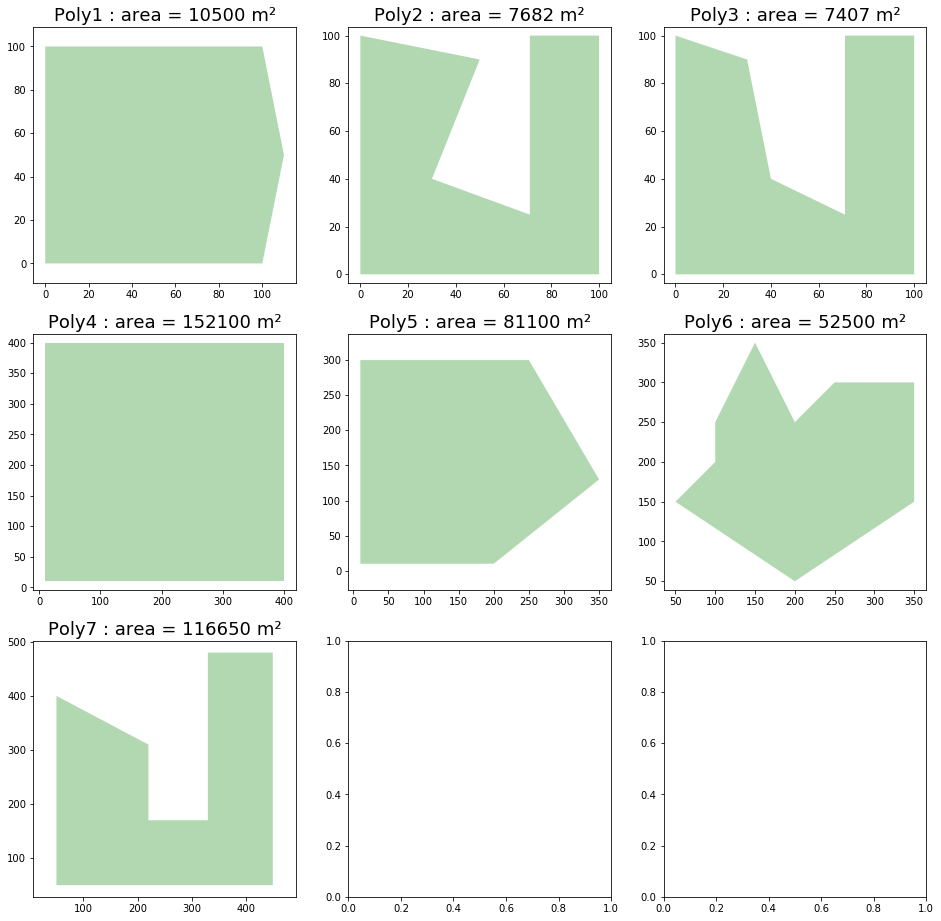

In [5]:
n_poly = len(POLY_LIST)
m = int(sqrt(n_poly)) + 1
fig, ax = plt.subplots(m, m, figsize=(16,16))
for i in range(n_poly):
    LAND = POLY_LIST[i]
    ax = plt.subplot(m, m, i+1)
    ax.set_title(f"Poly{i+1} : area = {int(abs(SympyPolygon(*LAND).area))} m²", fontsize=18)
    draw_polygon(LAND, color=get_color("Land"))
plt.plot()

<a id="hyperparameters"></a> 
## Hyperparameters and builder initialization

You can change the hyperparameters here if you want. A builder has been created to instantiate the optimizers, you can see the code in the OptimizerBuilder.ipynb.

In [6]:
# Common parameters
DIM = 5
NB_PARTICLES = 60
NB_CYCLES = 800
LAND = poly7

# PSO specific
PSI, CMAX = 0.17, 1.47
# DE specific
CR, F = 0.9, 0.8

# Common operating parameters
# for the evaluation function
ACCEPT_WHEN_INVALID_MOVE = False
# for the logs and historization of data
LOG_PADDING = 50
SHOW_LOGS = False

In [7]:
BUILDER = OptimizerBuilder(LAND,
                           accept_when_invalid_move = ACCEPT_WHEN_INVALID_MOVE,
                           dim=DIM, 
                           n_agents=NB_PARTICLES, 
                           n_cycles=NB_CYCLES,
                           log_padding=LOG_PADDING,
                           isbetter_func=lambda f1, f2: f1 > f2,
                           show_logs=SHOW_LOGS)

<a id="section2"></a>
## 2 - Particule Swarm Optimization
<a href="#tableOfContents">Go back to the table of contents</a>

The PSO class is declared in the PSO.ipynb notebook.

In [8]:
pso_optimizer = BUILDER.build_PSO(PSI=PSI, CMAX=CMAX)

### Visualization

In [9]:
erase_logs("PSO")
pso_optimizer.fit()

100%|██████████| 800/800 [00:02<00:00, 319.43it/s]


In [10]:
create_animation(LOGS["PSO - Swarm"], LAND, "Swarm")

In [11]:
create_animation(LOGS["PSO - Best"], LAND, "Best")

In [12]:
printmd(f"### Best fitness = **{pso_optimizer.best_agent['bestfit']}**")

### Best fitness = **43971.890137703194**

We observe that 800 iterations is not enough for the PSO to improve the global optimum with these hyperparameters. Let's keep 60 agents and 800 iterations to compare with DE.

<a id="section3"></a>
## 3 - Differential Evolution
<a href="#tableOfContents">Go back to the table of contents</a>

The DE class is declared in the DE.ipynb notebook.

In [13]:
de_optimizer = BUILDER.build_DE(CR=CR, F=F)

### Visualization

In [14]:
erase_logs("DE")
de_optimizer.fit()

100%|██████████| 800/800 [00:01<00:00, 643.91it/s]


In [15]:
create_animation(LOGS["DE - Swarm"], LAND, "Swarm")

In [17]:
printmd(f"### Best fitness = **{de_optimizer.best_agent['fit']}**")

### Best fitness = **48520.999797301076**

We observe that DE find the optimum and improve it quicker than PSO. 300 iterations is enough for DE.

<a id="section4"></a>
## 4 - Optimizers comparison
<a href="#tableOfContents">Go back to the table of contents</a>

To compare the optimizers fairly we should evaluate the following criterias
- **Average iteration number** required to reach the global optimum
- **Average optimization value**
- **Rate of reach** of the global optimum

**We will prefer the Wilcoxon test :**

A good statistic test that is easier to set up is the Wilcoxon test. By calculating the medians over several instances of the problem for the two optimizers we can deduce the difference between the two optimizers.

But this test ignores the time necessary to find the optimum and the number of iteration required. It is also unable to determine the most robust or the most precise of the two.

***

The comparison is based on the current state of the optimizers. Indeed, the results are intrinsically linked to the hyperparameters given to the optimizers.

**To be sure to compare them fairly we should first find the best hyperparameters for them**

We decided here to compare them without optimizing their hyperparameters. **So we suppose that the two optimizers are equivalent**

First, we want to find a compromize in the hyperparameters to compare DE and PSO. If, with the given set of hyperparameters (60/800) DE is still better than PSO we will increase the number of iterations. **Then, if DE is still better we would like to improve the PSO algorithm to reach the robustness and effectiveness of DE for this problem.**

### Functions to fit the optimizers many times

Extract the fitness over several instances of the problem

In [45]:
def run_n_times(optimizer, n_runs, optimizer_label="Opt?", show=False, land=LAND):
    global LOGS
    if show:
        m = int(sqrt(n_runs - 1)) + 1
        fig, ax = plt.subplots(m, m, figsize=(16, 16))
        fig.suptitle(f"{optimizer_label} - {n_runs} runs comparison", fontsize=24)
    erase_logs(optimizer_label)
    times = []
    for i in range(n_runs):
        start_time = time.time()
        print("Current run :", i)
        optimizer.fit()
        times.append(time.time() - start_time)
        if show:
            ax = plt.subplot(m, m, i+1)
            ax.set_title(f"Trial {i+1}: fit = {int(optimizer.best_agent['fit'])} m²", fontsize=18)
            draw_polygons([land, Rectangle(*optimizer.best_agent['pos']).to_rect()], colors=[get_color("Land"), get_color("Best final")])
        clear_output(wait=True)
    if show:
        plt.plot()
    return times

In [46]:
def get_scores(optimizer_label, optimizer_params, lands, n_runs, show=False):
    global BUILDER, LOGS
    scores = pd.DataFrame(columns=["land", "fitness", "iteration", "polygons"])
    land_number = 1
    for land in lands:
        land_name = "Poly" + str(land_number)
        print("Current poly :", land_name)
        BUILDER.set_land(land)
        optimizer = BUILDER.build(optimizer_label, *optimizer_params)
        run_n_times(optimizer, n_runs, optimizer_label, show=show, land=land)
        runs_df = pd.DataFrame(LOGS[f"{optimizer_label} - Best final"])
        runs_df = runs_df[["fitness", "iteration", "polygons"]]
        runs_df['land'] = land_name
        
        scores = scores.append(runs_df)
        land_number += 1
    return scores

### Comparison with **60 agents and 200 iterations**

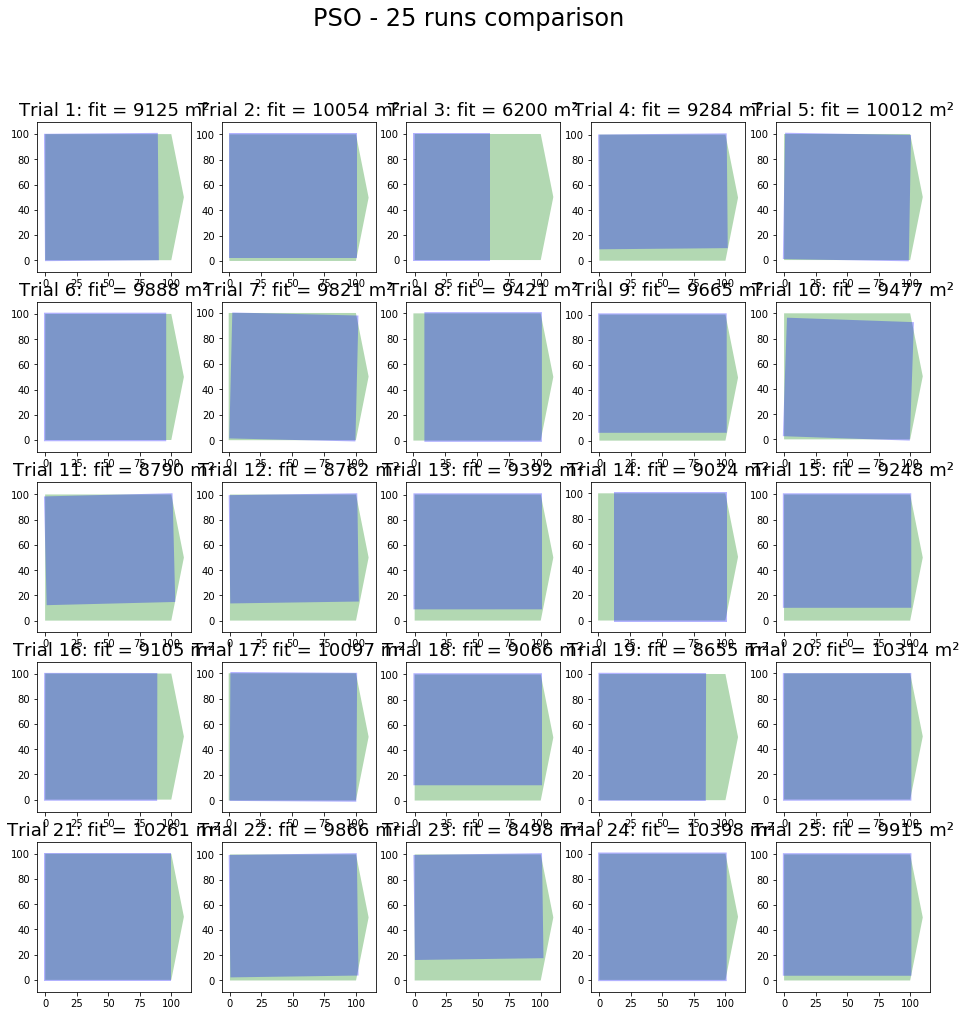

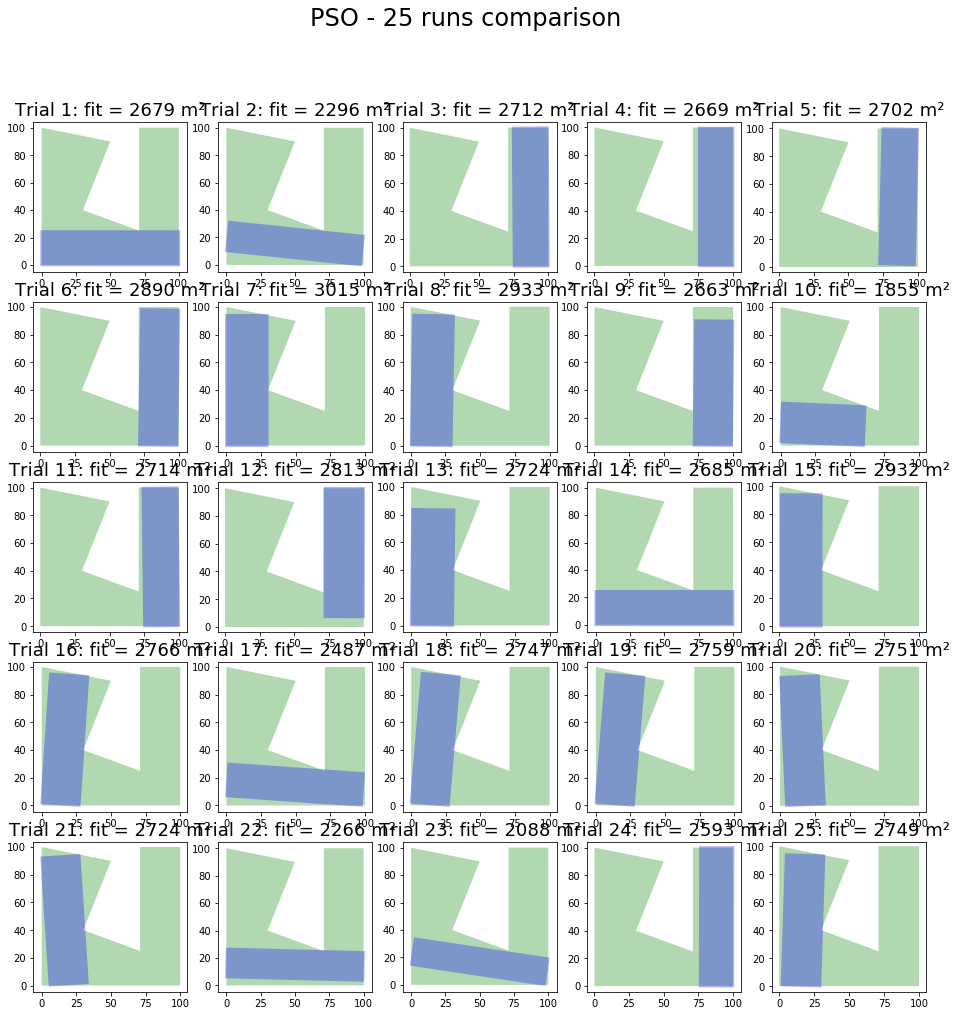

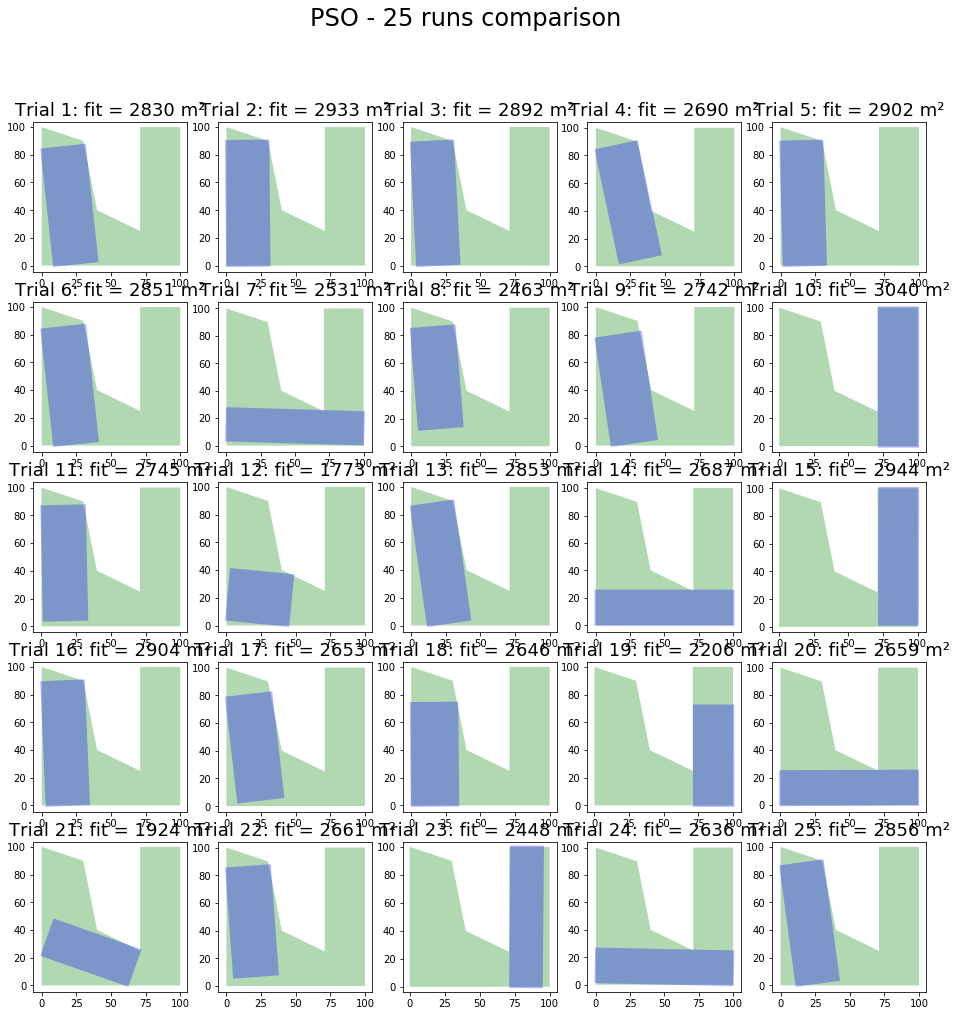

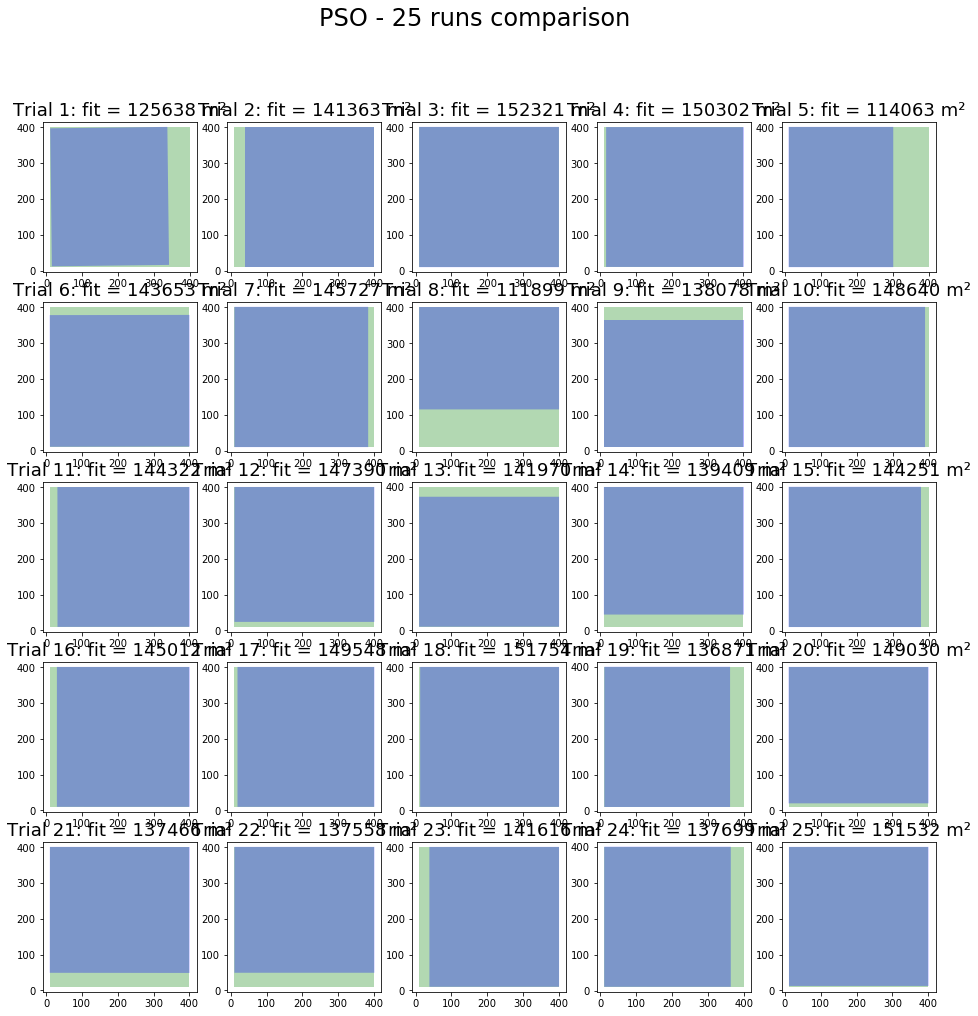

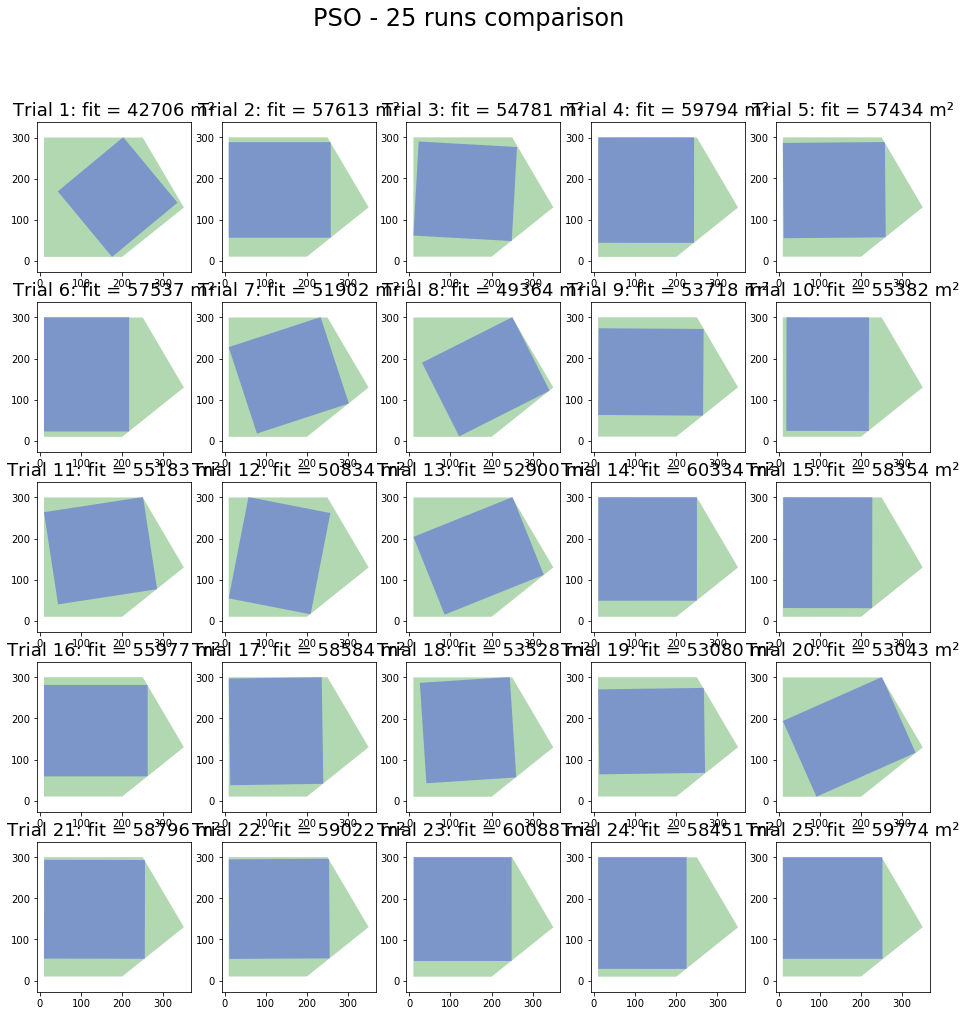

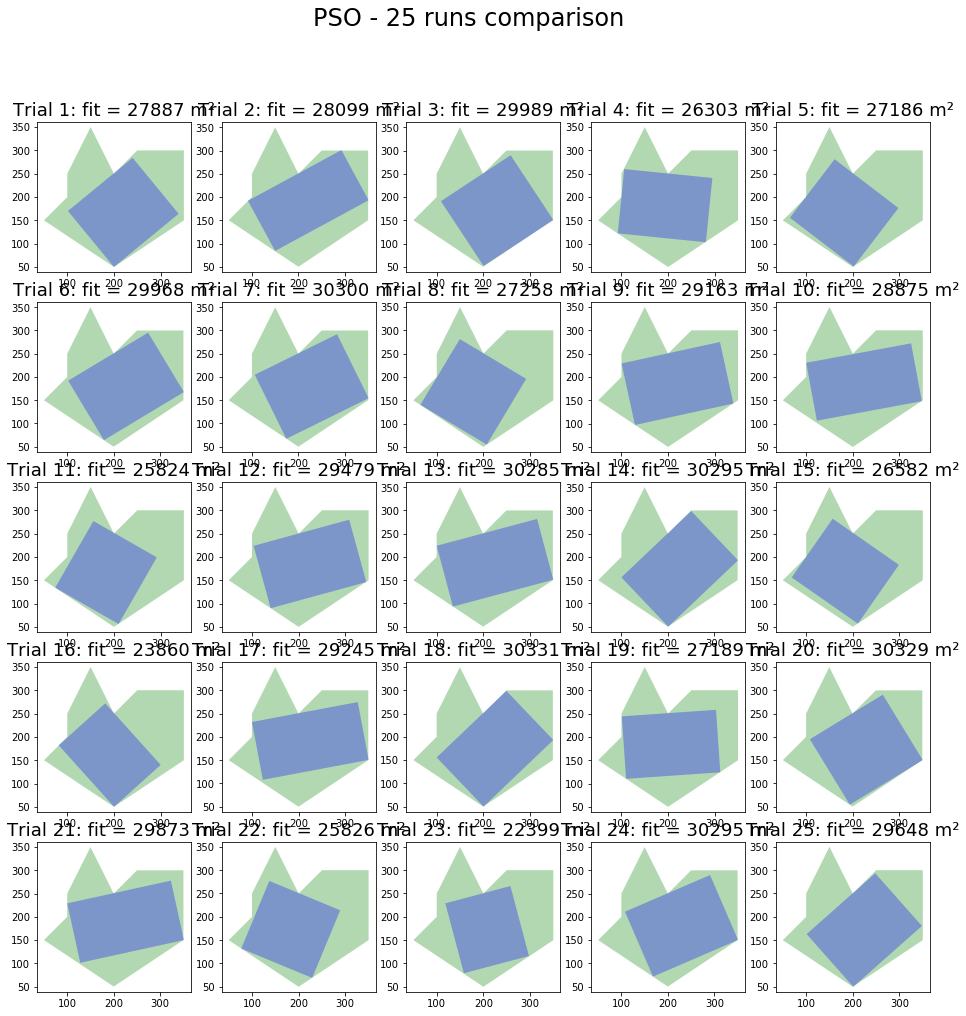

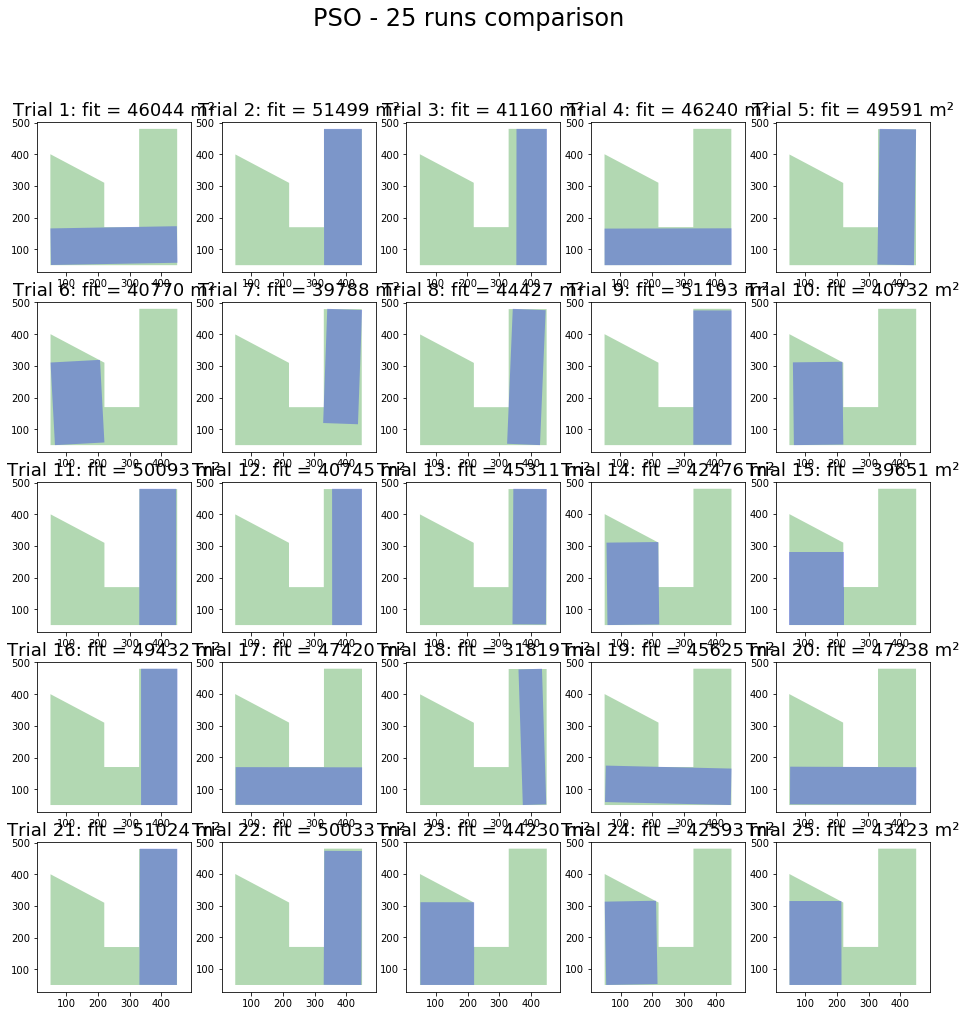

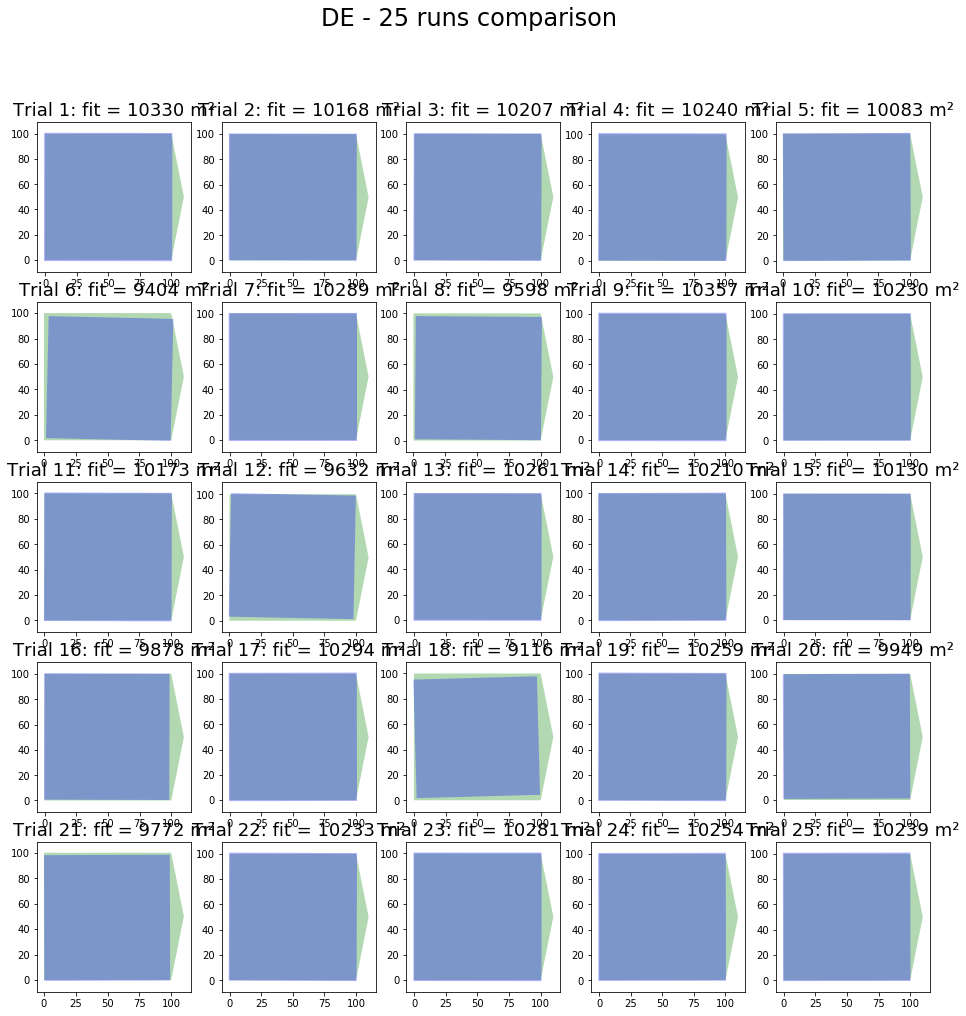

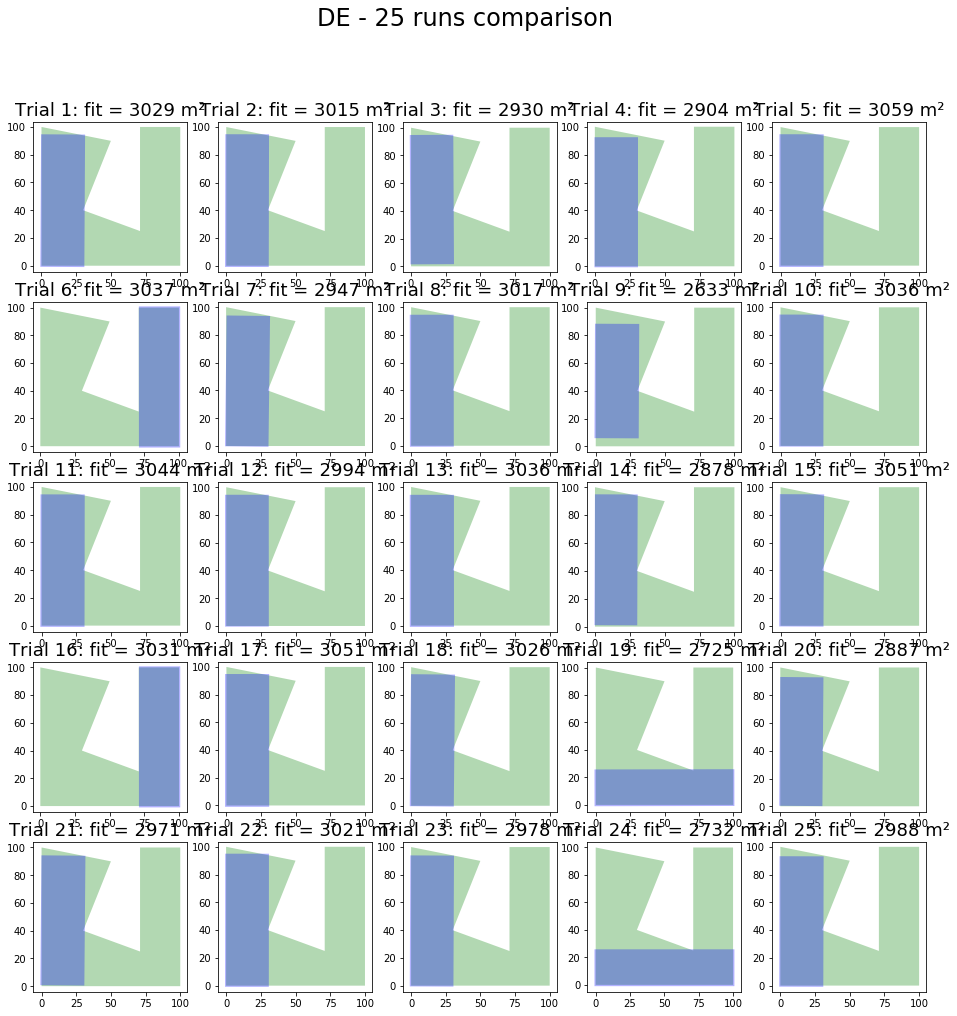

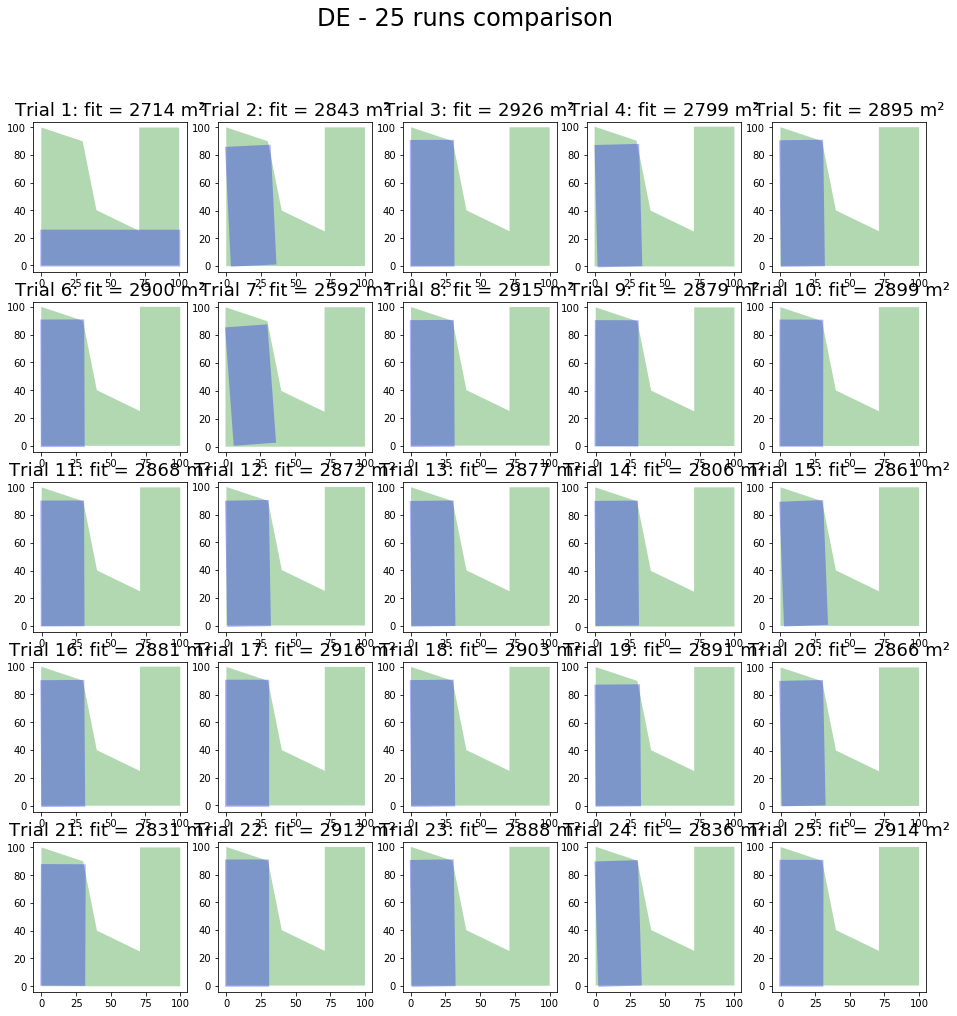

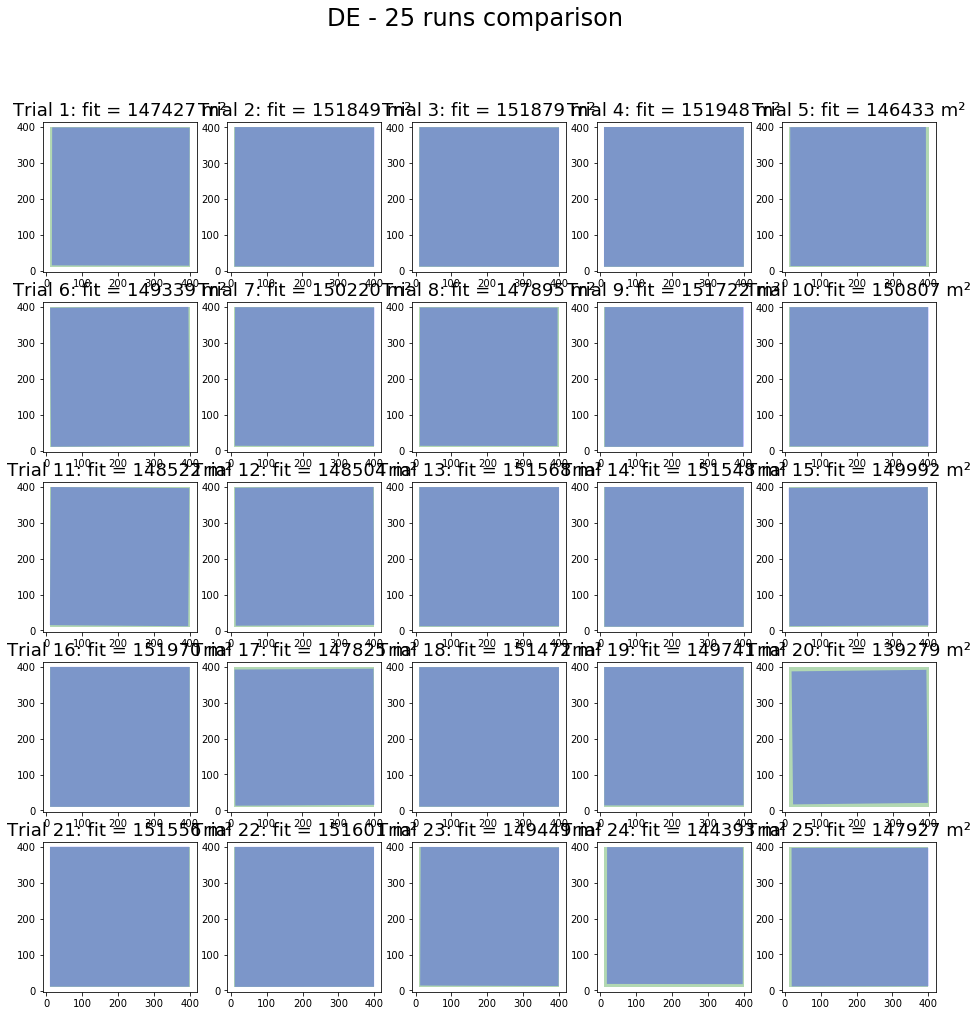

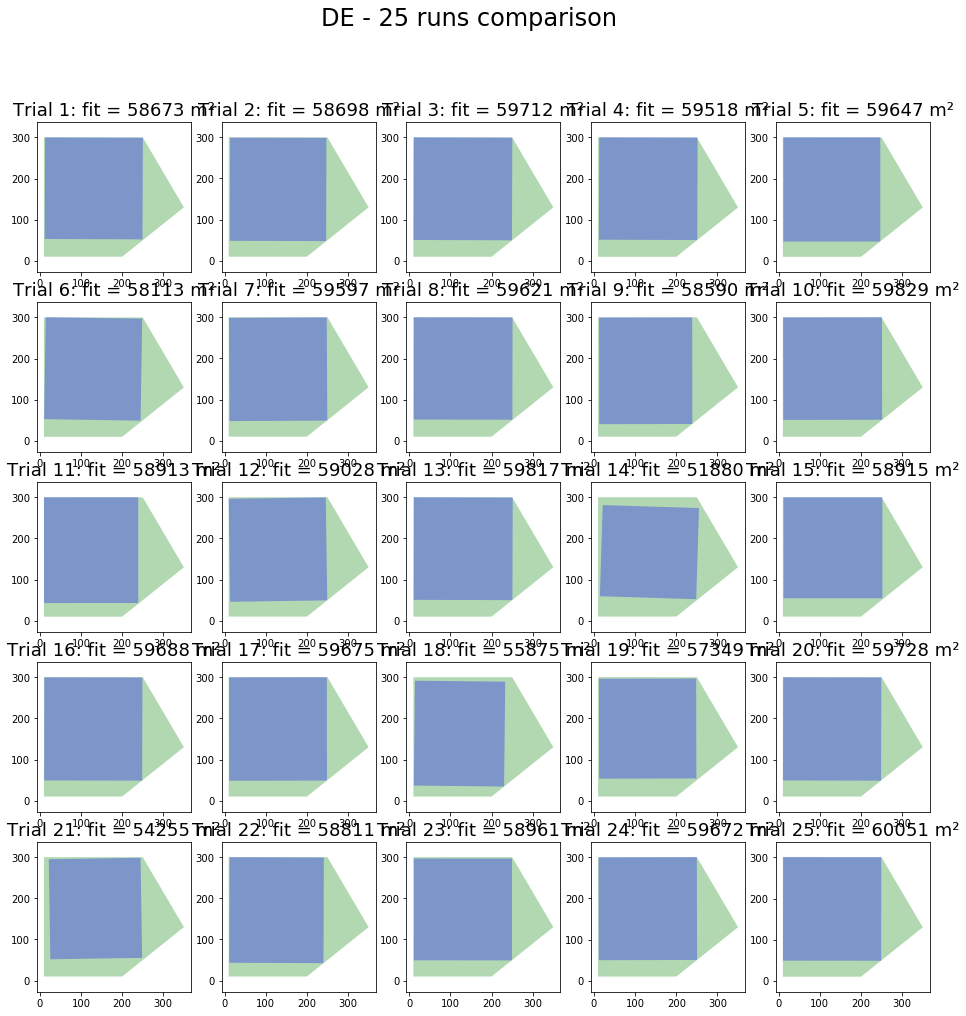

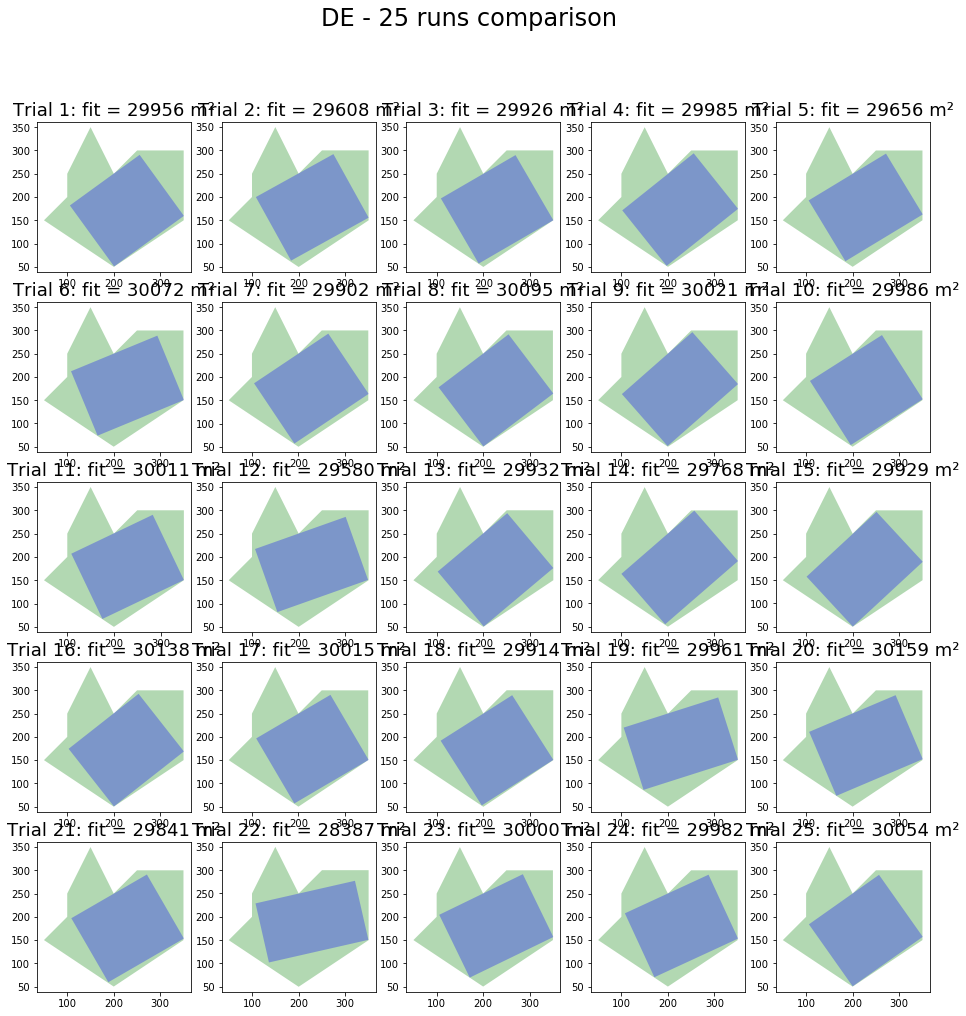

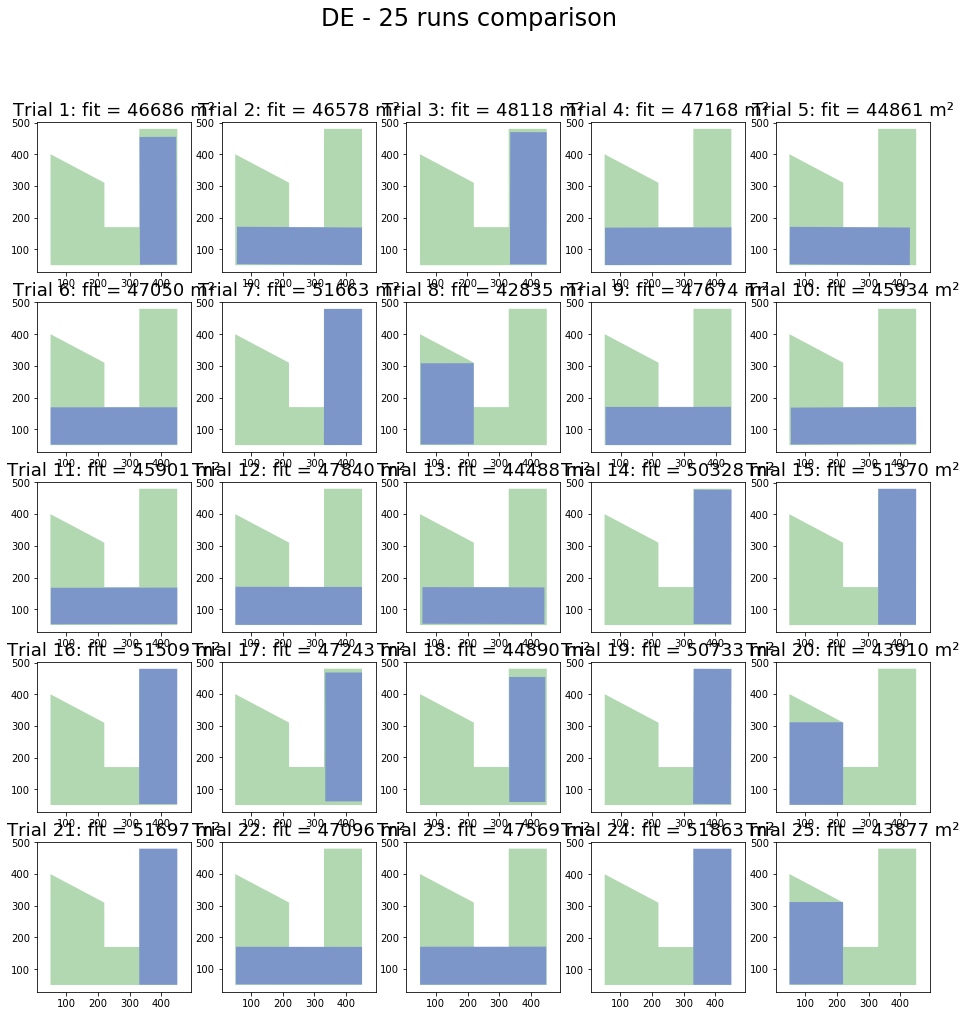

In [47]:
BUILDER.n_agents = 60
BUILDER.n_cycles = 200
pso_scores = get_scores(BUILDER.PSO_label, [PSI, CMAX], POLY_LIST, 25, show=True)
de_scores = get_scores(BUILDER.DE_label, [CR, F], POLY_LIST, 25, show=True)

In [51]:
log_file_v1 = 'logs/nbAgents=60_it=200_nRuns=25_polys=7.h5'
pso_scores.to_hdf(log_file_v1, key='pso_scores', mode='w')
de_scores.to_hdf(log_file_v1, key='de_scores', mode='a')

/home/siribarne/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['land', 'iteration', 'polygons'], dtype='object')]

  pytables.to_hdf(


In [52]:
pso_scores = pd.read_hdf(log_file_v1, 'pso_scores')
de_scores = pd.read_hdf(log_file_v1, 'de_scores')
display(pso_scores)
display(de_scores)

pso_medians = [float(pso_scores.loc[pso_scores['land'] == poly_name][['fitness']].median()) for poly_name in POLY_NAMES]
de_medians = [float(de_scores.loc[de_scores['land'] == poly_name][['fitness']].median()) for poly_name in POLY_NAMES]
print("PSO medians :", pso_medians)
print("DE medians :", de_medians)

,land,fitness,iteration,polygons
0,Poly1,9125.199865,200,"[[90.1332222384833, -0.02893937328550066, 89.3..."
1,Poly1,10054.028143,200,"[[-0.542707509642996, 1.9871476089412574, 100...."
2,Poly1,6200.768763,200,"[[59.79189657213669, -0.9999237127497339, 59.7..."
3,Poly1,9284.162403,200,"[[-0.14071471674865177, 9.026288059700072, 101..."
4,Poly1,10012.326561,200,"[[98.89945966909977, -0.9998603121818381, 100...."
...,...,...,...,...
20,Poly7,51024.856971,200,"[[332.4909453969286, 480.9999890457518, 330.99..."
21,Poly7,50033.217575,200,"[[447.39735845996495, 50.006947541863724, 449...."
22,Poly7,44230.396676,200,"[[51.525163999804285, 311.11060275678443, 51.3..."
23,Poly7,42593.237378,200,"[[211.99925314758772, 315.77055783104424, 50.0..."


,land,fitness,iteration,polygons
0,Poly1,10330.875785,200,"[[100.73187245669713, -0.9993658975652423, 100..."
1,Poly1,10168.088657,200,"[[-0.578570508836886, 100.5162827997627, -0.76..."
2,Poly1,10207.724854,200,"[[100.73506108607758, 100.30358894492228, -0.4..."
3,Poly1,10240.811355,200,"[[100.98321259026419, 100.7501791974877, -0.45..."
4,Poly1,10083.386641,200,"[[100.18699884166703, 100.50719252254781, -0.1..."
...,...,...,...,...
20,Poly7,51697.210212,200,"[[330.28345066954785, 480.3189809743757, 330.3..."
21,Poly7,47096.479099,200,"[[450.27345383317515, 170.1525042968453, 52.38..."
22,Poly7,47569.391454,200,"[[448.23395504712005, 170.95678517571756, 50.4..."
23,Poly7,51863.339269,200,"[[450.7397839277837, 50.57842552727852, 450.86..."


PSO medians : [9421.91643147461, 2712.7445016243432, 2690.3224605988758, 143653.81363318086, 55977.551882027205, 29163.33410420736, 45311.607262522135]
DE medians : [10210.255321008508, 3015.5790940166007, 2879.792810720408, 149992.05909942507, 59028.903376529495, 29961.8872077864, 47168.80775577753]


In [53]:
wilcoxon_pvalue = wilcoxon([pso_medians[i] - de_medians[i] for i in range(len(pso_medians))]).pvalue
printmd(f"The wilcoxon test return a **pvalue = {wilcoxon_pvalue}**")

The wilcoxon test return a **pvalue = 0.015625**

The pvalue is between 0.01 and 0.05. So we strongly assume that the 2 optimizers are different.

Looking at the medians we can say that **Differential Evolution is better**.
Looking at the graphs we can see that PSO does not reach the best value of the detected optimum. Let's try to increase the iteration number.

### Comparison with **90 agents and 2000 iterations**

/home/siribarne/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['land', 'iteration', 'polygons'], dtype='object')]

  pytables.to_hdf(


,land,fitness,iteration,polygons
0,Poly1,9950.055789,2000,"[[-0.4568362922474534, 2.480956228081644, 101...."
1,Poly1,6685.432012,2000,"[[78.2692915701061, -0.9950100987624158, 102.9..."
2,Poly1,10253.649415,2000,"[[0.4614103326318377, 100.99369277507643, 0.46..."
3,Poly1,7640.344994,2000,"[[95.71984102304319, 95.88892787054091, -0.999..."
4,Poly1,10399.836555,2000,"[[100.99910278697, -0.9999356045064733, 100.99..."
...,...,...,...,...
20,Poly7,52089.488387,2000,"[[330.04211861827133, 480.99976235189627, 330...."
21,Poly7,47624.001626,2000,"[[450.9992334048258, 168.99987435450956, 50.81..."
22,Poly7,46665.909513,2000,"[[330.00000000102625, 95.33132633589004, 450.9..."
23,Poly7,43355.927110,2000,"[[213.6086529516812, 50.0, 213.6122755530661, ..."


,land,fitness,iteration,polygons
0,Poly1,10404.0,2000,"[[-0.9999999999999947, -0.9999999999999806, 10..."
1,Poly1,10404.0,2000,"[[100.99999999999999, 100.99999999999999, -0.9..."
2,Poly1,10404.0,2000,"[[-0.9999999999999953, 100.99999999999999, -0...."
3,Poly1,10404.0,2000,"[[100.99999999999999, -0.999999999999995, 100...."
4,Poly1,10404.0,2000,"[[100.99999999999999, -0.9999999999999951, 100..."
...,...,...,...,...
20,Poly7,52151.0,2000,"[[330.0, 480.99999999999994, 330.0, 50.0000000..."
21,Poly7,48521.0,2000,"[[450.9999999999999, 170.99999999999997, 50.00..."
22,Poly7,52151.0,2000,"[[330.0, 480.99999999999994, 330.0, 50.0000000..."
23,Poly7,48521.0,2000,"[[450.99999999999994, 170.99999999999997, 50.0..."


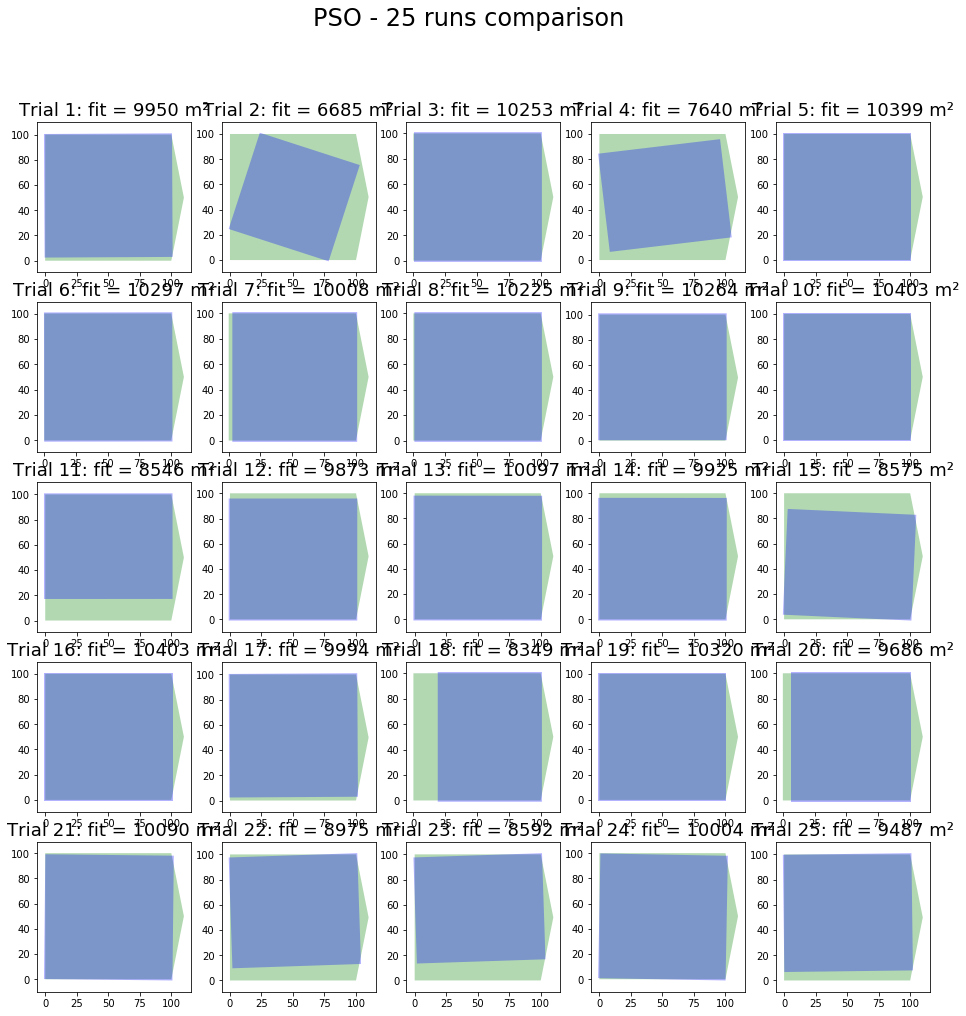

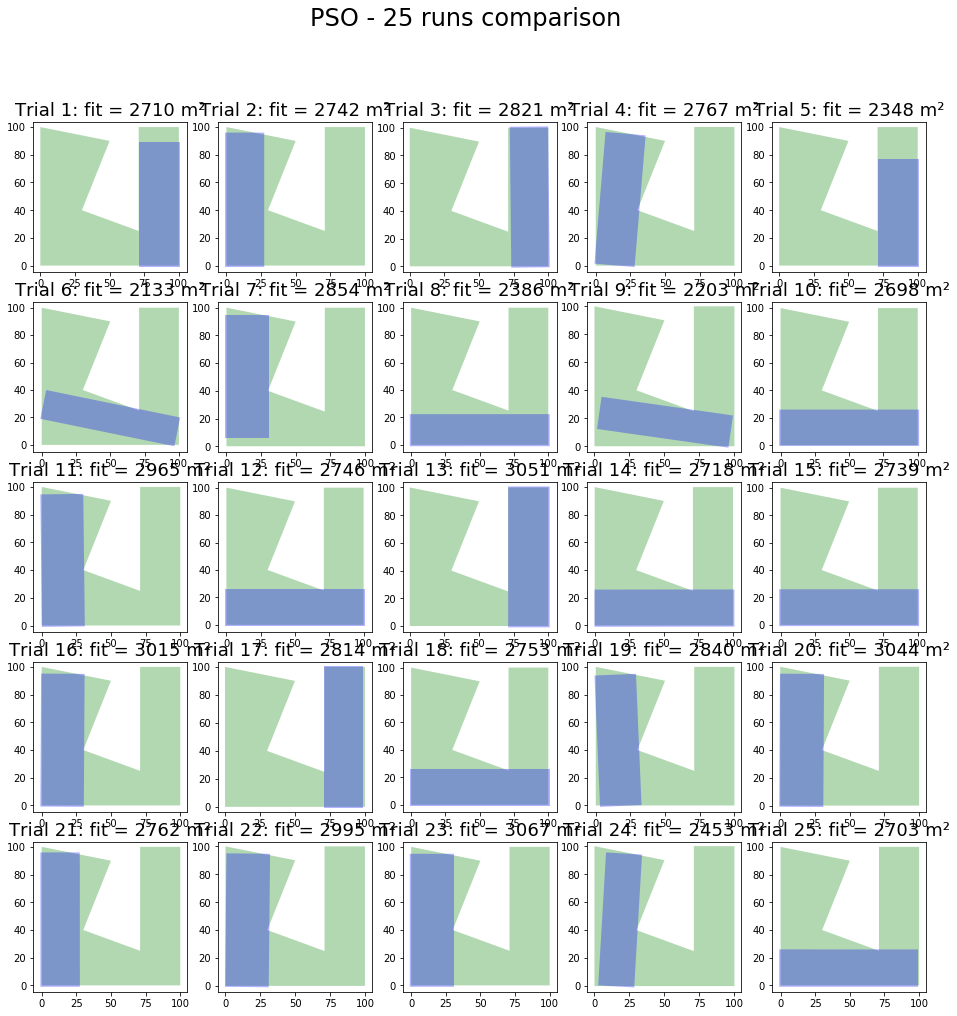

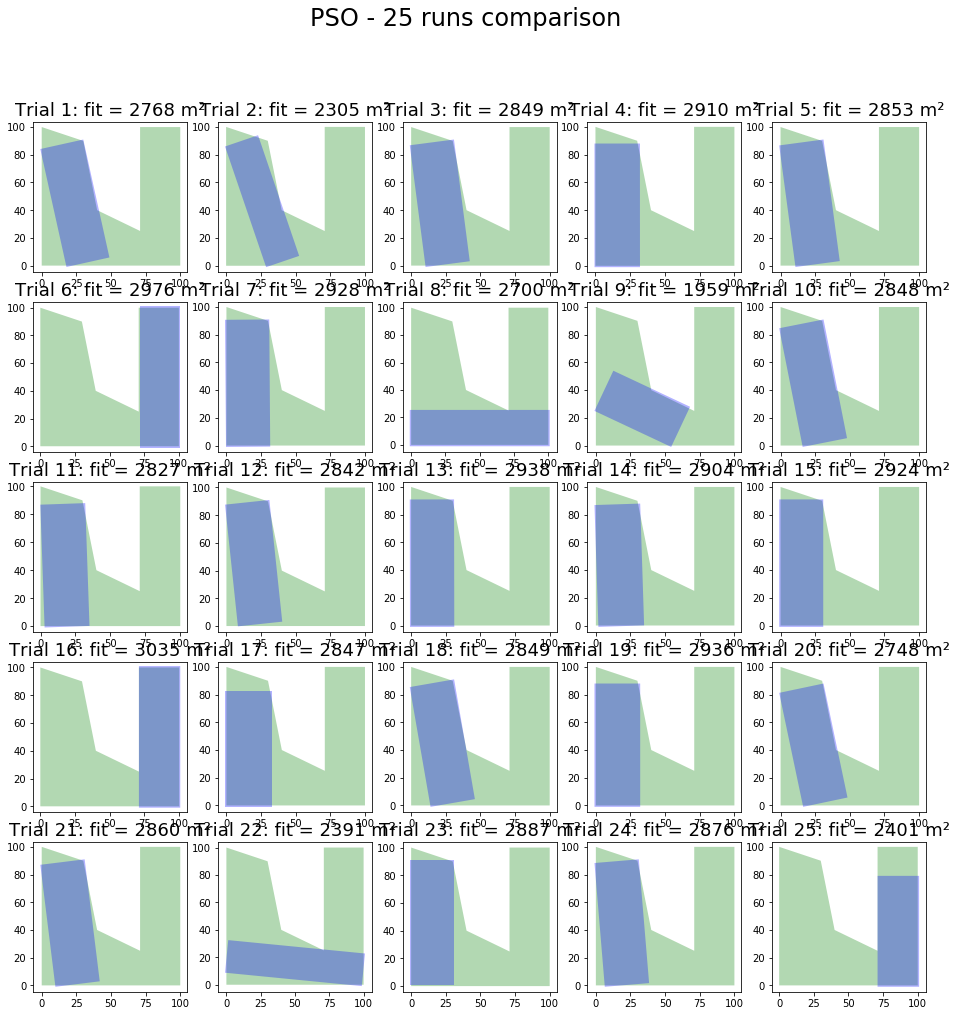

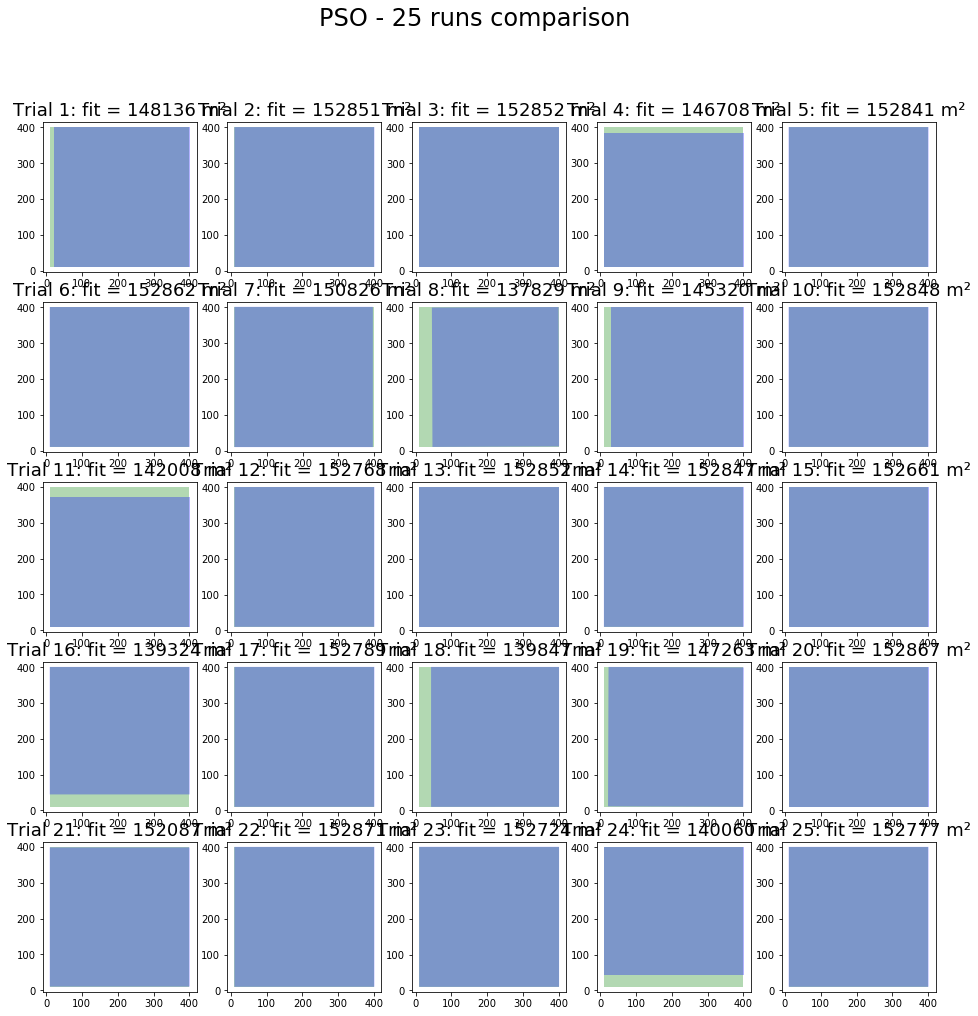

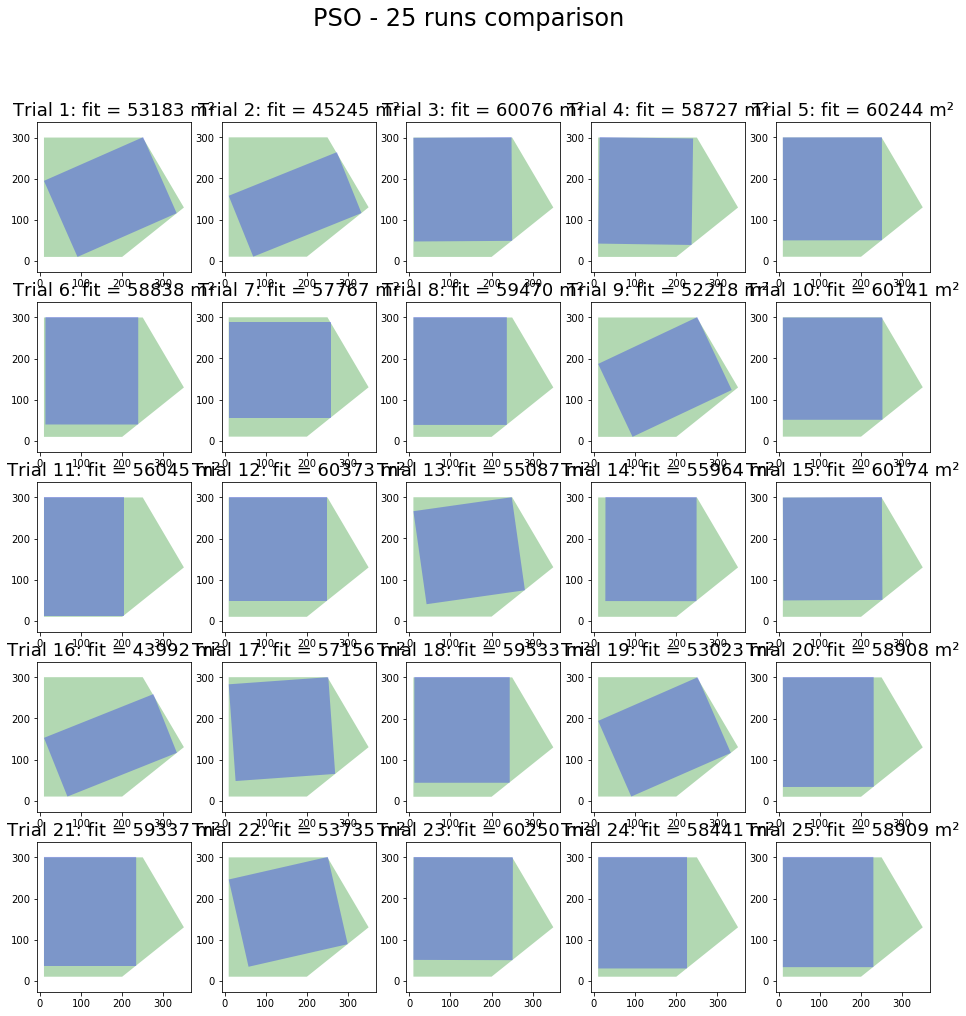

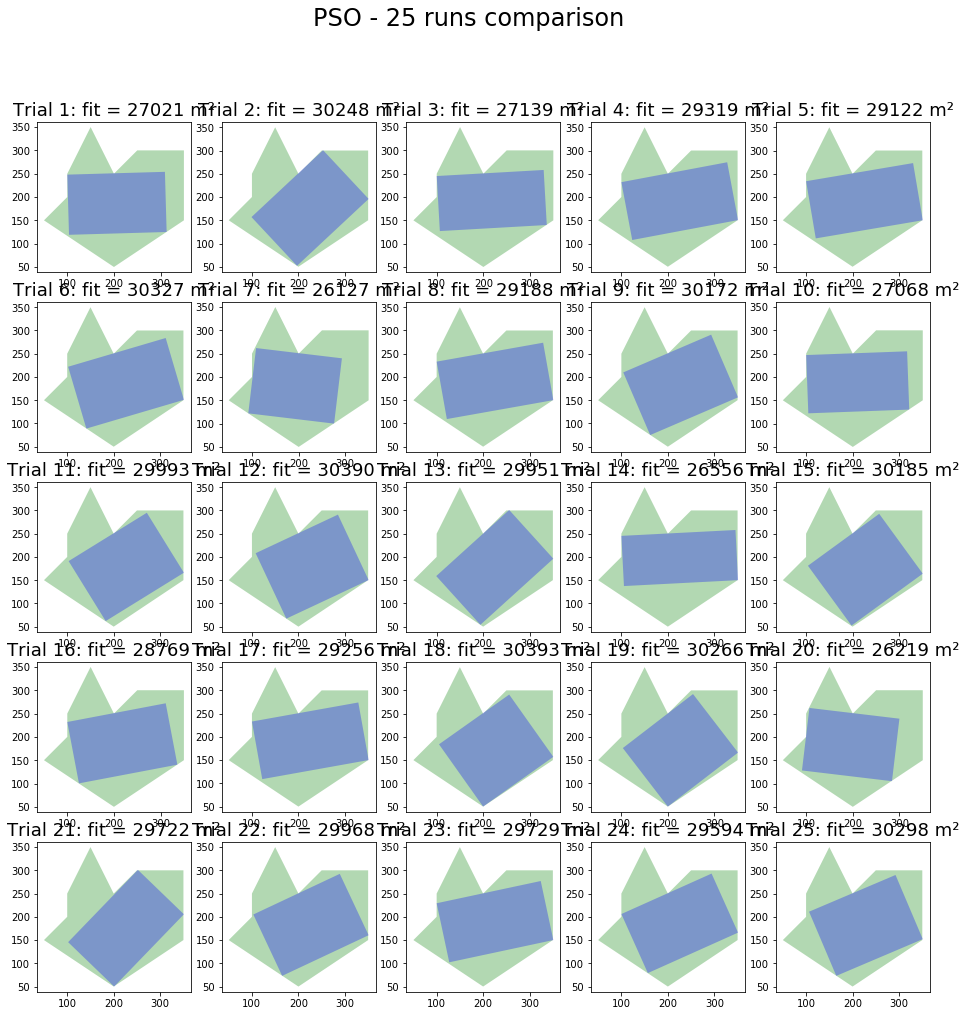

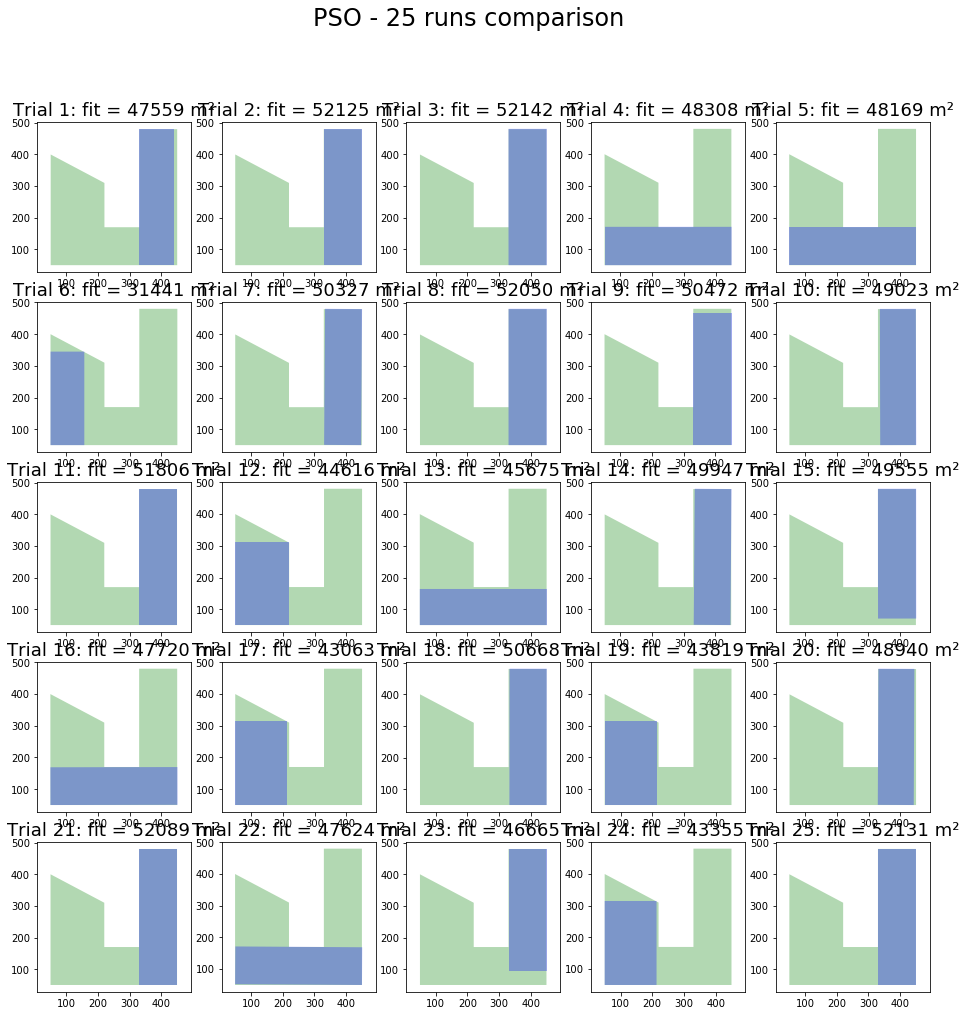

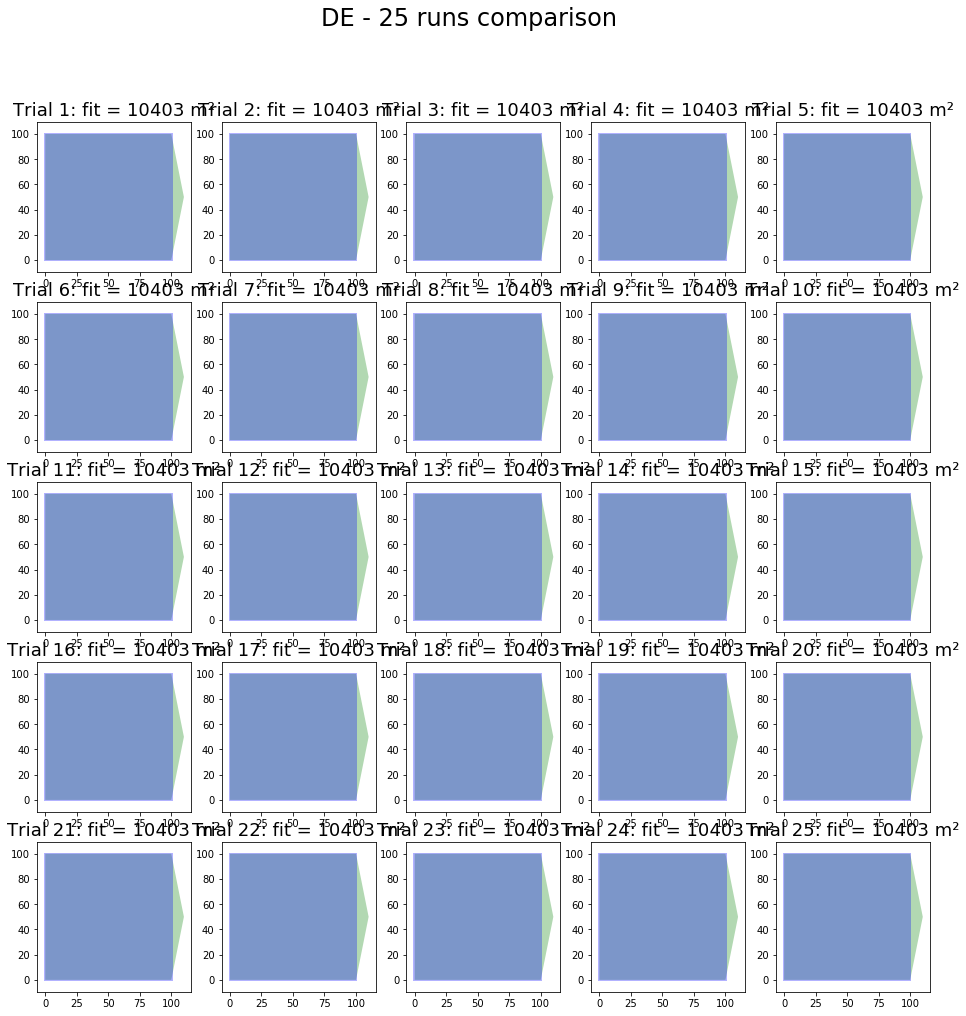

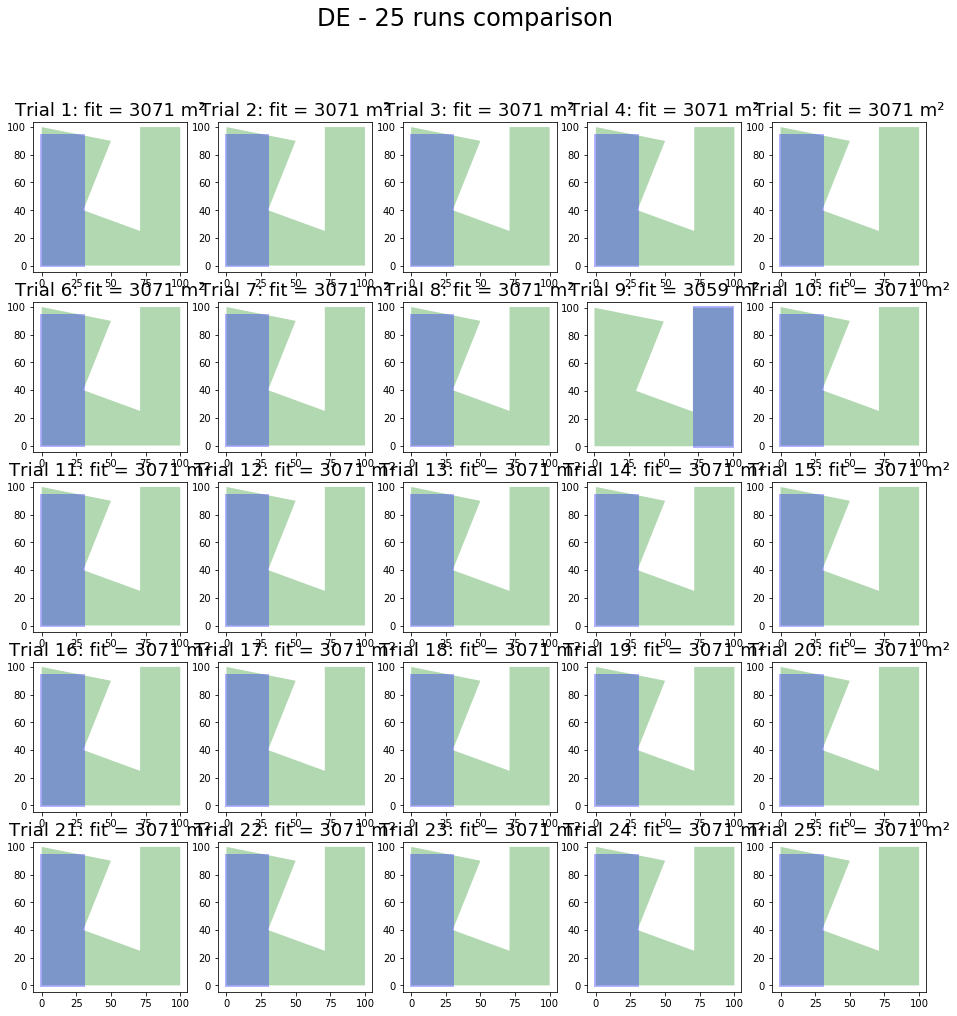

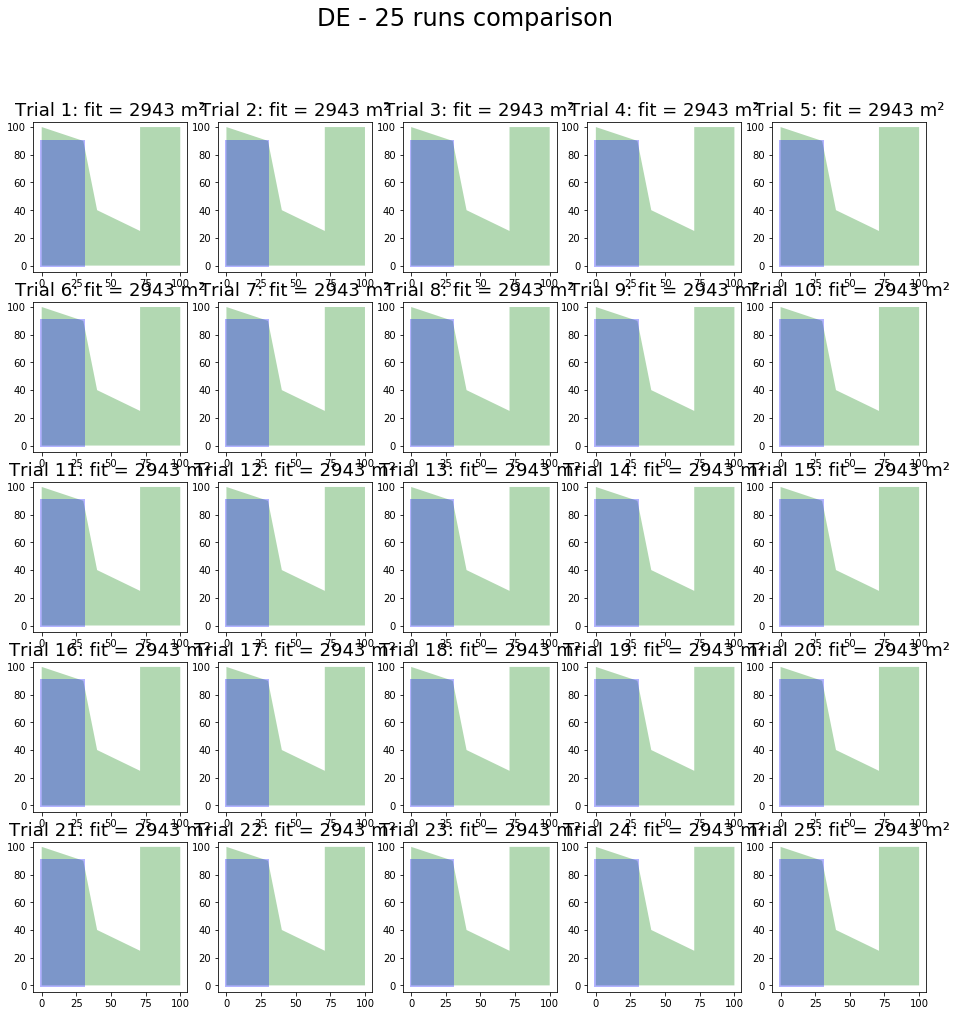

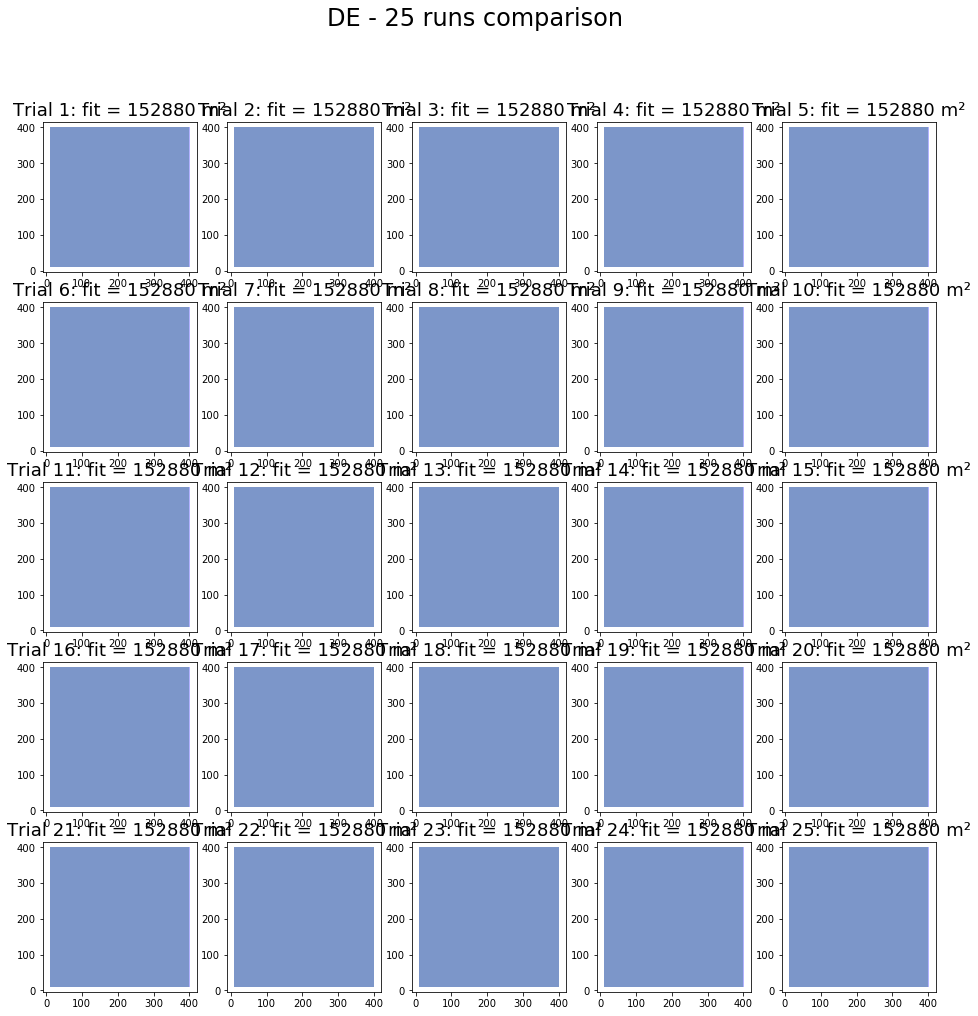

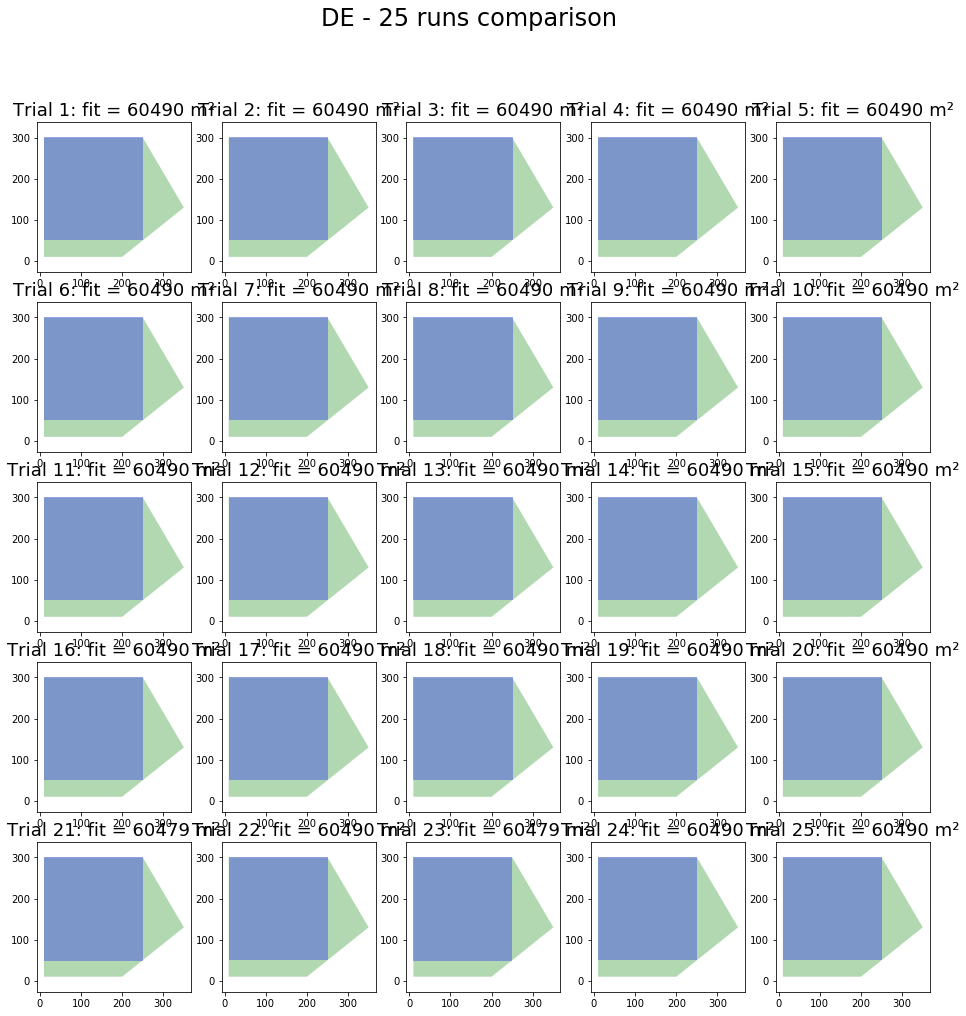

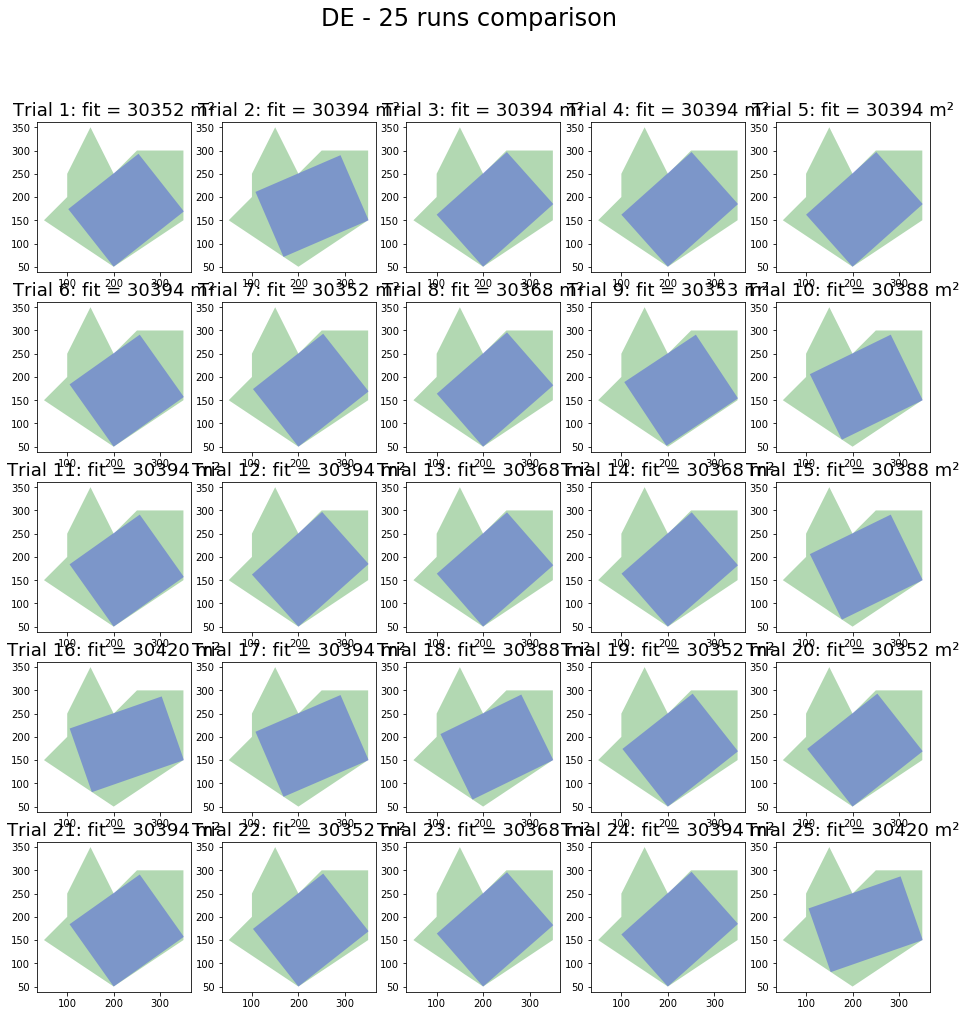

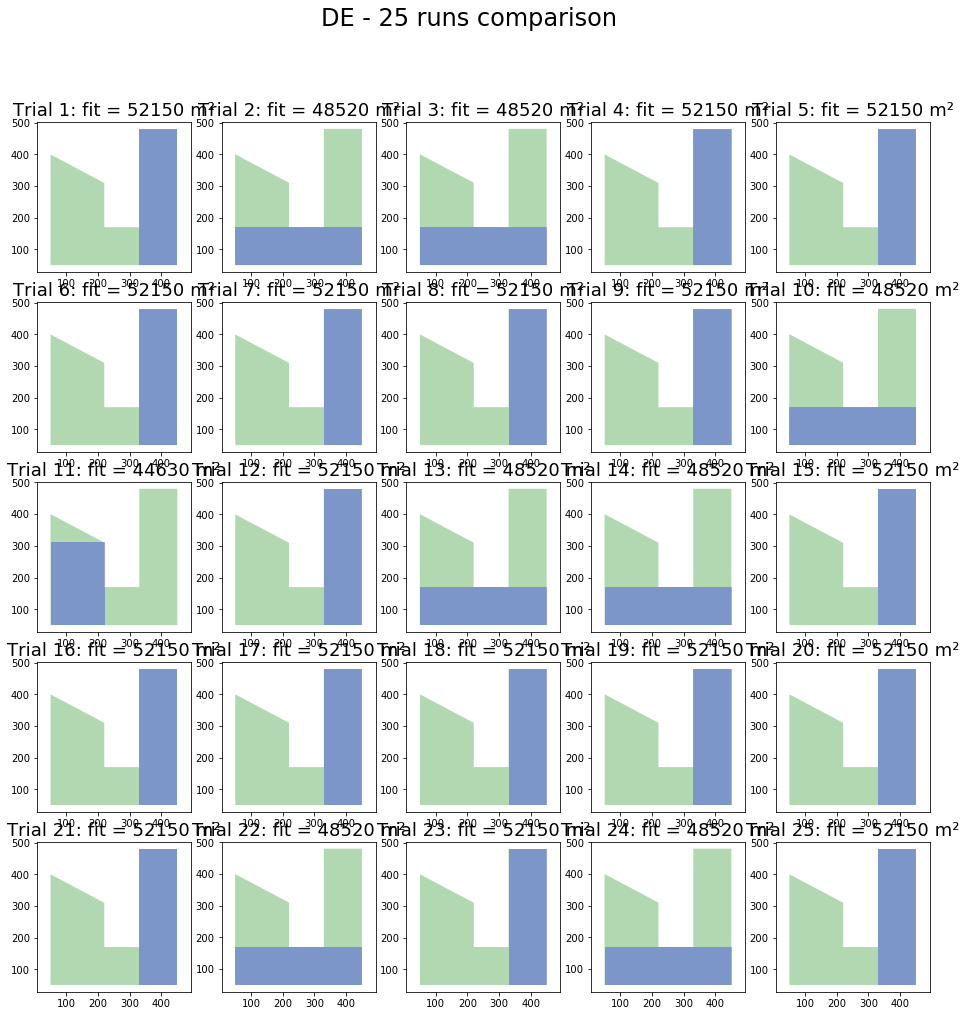

In [54]:
BUILDER.n_agents = 90
BUILDER.n_cycles = 2000
pso_scores = get_scores(BUILDER.PSO_label, [PSI, CMAX], POLY_LIST, 25, show=True)
de_scores = get_scores(BUILDER.DE_label, [CR, F], POLY_LIST, 25, show=True)

log_file_v2 = 'logs/nbAgents=90_it=2000_nRuns=25_polys=7.h5'
pso_scores.to_hdf(log_file_v2, key='pso_scores', mode='w')
de_scores.to_hdf(log_file_v2, key='de_scores', mode='a')

pso_scores = pd.read_hdf(log_file_v2, 'pso_scores')
de_scores = pd.read_hdf(log_file_v2, 'de_scores')
display(pso_scores)
display(de_scores)

In [ ]:
pso_medians = [float(pso_scores.loc[pso_scores['land'] == poly_name][['fitness']].median()) for poly_name in POLY_NAMES]
de_medians = [float(de_scores.loc[de_scores['land'] == poly_name][['fitness']].median()) for poly_name in POLY_NAMES]
print("PSO medians :", pso_medians)
print("DE medians :", de_medians)

In [ ]:
wilcoxon_pvalue = wilcoxon([pso_medians[i] - de_medians[i] for i in range(len(pso_medians))]).pvalue
printmd(f"The wilcoxon test return a **pvalue = {wilcoxon_pvalue}**")

The pvalue is between 0.01 and 0.05. So we strongly assume that the 2 optimizers are different.
As the previous comparizon, **DE is still better than PSO**, even with an increase of the iterations and agents number.

<a id="section5"></a>
## 5 - Comparizon result
<a href="#tableOfContents">Go back to the table of contents</a>

**For this problem, with these hyperparameters, and these implementations, DE is better than PSO :**

With 300 iterations and 30 agents DE can find the global optimum and exploit it. When 1000 iterations and 50 particles are necessary for PSO to get good results.
Moreover, DE is faster than PSO.
Hence, with <a href="#section4">this metrics</a> (less iteration number, better optimization value, rate of reach the optimum, time for the calculation) we can ensure that the implementation of DE is better than the implementation of PSO.
**Here, DE is more robust, finds the global optimum faster and have a better average optimization value**.

Indeed, the implementation of PSO is a vanilla implementation. The next step would be to improve the PSO algorithm to allow each particle to move according to its neighbors and no longer only to the best particle of the field.